# Introduction to Reinforcement Learning for Economists

The purpose of this post is to introduce some basic concepts from the reinforcement learning (RL) literature using the setting and notation that is familiar to economists studying infinite horizon dynamic decision problems. In particular, I make use of Rust (1987)'s bus engine replacement problem and follow many of the notational conventions therein. 

**Note**: the methods discussed here are mainly concerned with solving the dynamic problem, and not with estimation.

For those unfamiliar with RL, here are some recent breakthrough examples of these methods
- [AlphaGo beating human Go champion](https://www.youtube.com/watch?v=8tq1C8spV_g)
- [Playing Atari games by only observing raw image input](https://www.youtube.com/watch?v=dJ4rWhpAGFI)
- [Robotic manipulation of arbitrary objects](https://www.youtube.com/watch?v=ZhsEKTo7V04)

What is notable about these applications?

They all involve notable **complexity**:
1. A complex/large state space, as in the case of Go
2. Complex transition dynamics, which are analytically intractible, as in the case of Atari games
3. Complex policy functions, as is the case with the large number of motors involved in robotic manipulation


The reader should keep these more complex applications in mind. This notebook focuses on a simple case for expositional purposes, with some particular feature that make classical methods far more appealing than RL, but the real power of the latter methods is only apparent in much more complex situations.

---

# Setup and Notation

The methods presented here are appropriate for **finite Markov Decision Processes**, characterized by the following:

States: $x \in \mathcal{X}$, finite

Actions: $a \in \mathcal{A}(x)$, finite

Transition probabilities: $p(x'|x,a)$

Flow utility: $u(x,a)$

Discount rate: $\beta$

Policy function (or choice probability): $f(a,x) = Pr(a|x)$

The agent's problem:
$$
\begin{align}
\max_{f} \mathbb{E}_{x_1,x_2,\dots} &\Big[ \sum_{t=0}^\infty \beta^t u(x,a) | x_0 \Big] \\
&s.t. \\
Pr(a_t|x_t) &= f(a_t,x_t) \\
Pr(x_{t+1}|x_t) &= \sum_{a\in\mathcal{A}(x)}f(a,x)p(x_{t+1}|x_t,a) \\
\end{align}
$$

**Note**: in general, the optimal policy functions will be degenerate, such that $f(a^*,x)=1, \quad f(a,x)=0, \quad \forall a \neq a^*$

We can write the problem in recursive form using the Bellman equation

$$
V(x) = \max_{a \in \mathcal{A}(x)} u(x,a) + \beta \sum_{x' \in \mathcal{X}} V(x') p(x'|x,a)
$$


In [2]:
import random
import matplotlib.pyplot as plt
import torch

class dynamic_problem:
    def __init__(self, nbX, nbA, P, u, β):
        self.nbX = nbX
        self.nbA = nbA
        self.P = P
        self.u = u
        self.β = β

# Bus Engine replacement

Recall the problem studied by Rust (1987):
1. Bus engines get worn over time and require increasing amounts of maintenance each month.
2. Alternatively, the entire engine can be replaced at a high fixed cost

Here, the state variable $x$ represents the mileage of the engine. The actions space at every period is $\mathcal{A} = \{0,1\}$, where $1$ implies replacing the engine.

Utilities are:
- $u(x,0) = -c(x)$
- $u(x,1) = -R - c(0)$

with $c(x) = \theta x$. For the remainder, we fix $\theta = 8.6*10^{-4}$ and $R = 8000$.

The transition process for $x$ is s.t.:
- Conditional on $a_t = 0$,  $x_{t+1} - x_t \sim$ Exponential($\lambda$)
- Conditional on $a_t = 1$,  $x_{t+1} \sim$ Exponential($\lambda$)

This process will be discretized into a 201-point grid for $x \in [0, 300000]$ with a spacing of $1500$ miles in between points.

In [ ]:
nbX = 201
nbA = 2

# Constructing the x_grid and transition probabilities
λ = 1/1500

def exp_cdf(c:float, λ):
    return 1 - torch.exp(-λ * c)

x_grid = torch.linspace(0,3*10e4, nbX)
x_diff = torch.maximum(x_grid[:,None] - x_grid[None,:], torch.zeros(1)) # Get all the differences
x_diff = torch.cat([x_diff, torch.ones(1, nbX) * 1e36], 0)
P0 = exp_cdf(x_diff, λ) # Get CDFs at all the interval boundaries
P0 = P0[1:,] - P0[:-1,] # Convert to PMF of the intervals
P1 = P0[:,0][:,None].repeat(1,nbX) # Transition probabilities conditional on replacement is just transition probabilities from the first state. The syntax [:,None] adds an empty dimension at the specified place.
P = torch.stack([P0,P1],-1)

# Utilities
θ = 1e-3
R = 8000
u = lambda x : torch.stack([-θ*x, -torch.tensor(R).repeat(len(x))], -1).squeeze()

# Discount factor
β = 0.97

bus_problem = dynamic_problem(nbX, nbA, P, u(x_grid), β)
bus_problem.x_grid = x_grid

### Rust (1987) solution

Rust's approach uses the contraction mapping property of the Bellman equation to iterate over choice-specific value functions (which we will call **Q-functions**).

Let:
$$
Q(x,a) \equiv u(x,a) + \beta \sum_{x' \in \mathcal{X}} V(x') p(x'|x,a)
$$

Then we have the following contraction mapping:
$$
Q(x,a) = u(x,a) + \beta \sum_{x \in \mathcal{X}} p(x'|x,a) \arg \max_{y \in \mathcal{Y}(x)} Q_{x'y}
$$

This is almost the contraction mapping from Rust (1987), simply without the random utility component.

This can be iterated on $Q(x,a)$ to solve the problem. 

#### Algorithm

>Denote the current iteration by $k$. Initialize $k=0$, $Q^0$
>
>For every $k=0,1,\dots$:
>- $Q^{k+1}(x,a) = u(x,a) + \beta \sum_{x \in \mathcal{X}} p(x'|x,a) \arg \max_{a \in \mathcal{A}(x)} Q^k(x',a), \quad \forall (x,a)$
>- Stop when $|Q^k - Q^{k-1}| < \delta$

**Key point**: notice that at every iteration $k$, the update is performed over $|\mathcal{X}|\cdot|\mathcal{A}|$ points.

In [6]:
def cmap(self, Q_init, tol, max_iter = float('inf')):
    # Initialize
    Q_k = Q_init.clone()
    tol = 1e-8
    k = 0
    diff_hist = []
    diff = tol + 1

    while (diff > tol) & (k < max_iter):
        # Compute new Q
        Q_k1 = self.u +  self.β * torch.sum(self.P * Q_k.max(1)[0][:,None,None],0)
        
        # Record difference
        diff = torch.norm(Q_k1 - Q_k)
        diff_hist.append(diff)
        
        # Update Q
        Q_k = Q_k1
        
        k += 1
        
    diff_hist = torch.stack(diff_hist)
    if diff <= tol:
        print("Iteration converged after " + "{:,}".format(self.nbX*self.nbA*k) + " function updates") 
    else:
        print("Hit maximum iterations after " + "{:,}".format(self.nbX*self.nbA*k) + " function updates")         
    return Q_k, diff_hist

dynamic_problem.cmap = cmap

In [7]:
%%time
Q_init = torch.ones(bus_problem.nbX, bus_problem.nbA) * -2000
tol = 1e-8
Q_sol_rust, diff_hist_rust = bus_problem.cmap(Q_init,tol)

Iteration converged after 207,432 function updates
CPU times: user 254 ms, sys: 154 ms, total: 408 ms
Wall time: 78.7 ms


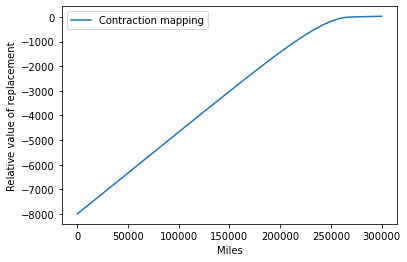

In [8]:
# Relative value of replacement
plt.plot(x_grid, Q_sol_rust[:,1]-Q_sol_rust[:,0], label = "Contraction mapping")
plt.xlabel("Miles")
plt.ylabel("Relative value of replacement")
plt.legend()

---
# Q-learning

Q-learning, introduced by Watkins (1989) is another way of solving such an MDP.

An intuitive description of Q-learning is "learning by doing". It makes use of simulation to iterate on the equation. This affects both which $(x,a)$ pairs are updated at each iteration and how they are updated.

We can break down this approach into two elements: asynchronous updating and stochastic iteration

---

### Asynchronous updating

Whereas  Rust (1987) updates every $(x,a)$ at every iteration, the basic Q-learning iteration only updates a single $(x,a)$ per iteration. The choice of $(x,a)$ is determined by simulation, so $y$ is chosen according to the current policy, while the new $x$ is then chosen according to the transition probabilities.


#### Algorithm

>Denote the current iteration by $k$. Initialize $k=0$, $x^0$, $Q^0$
>
>For every $k=0,1,\dots$:
>- $a^k = \arg \max Q^k_(x^k,a)$
>- Draw $x^{k+1}$ according to $p(x^{k+1}|x^k,a)$
>- Update:
>>  - If $(x,a) = (x^k,a^k)$: $Q^{k+1}(x,a) = u(x,a) + \beta \sum_{x \in \mathcal{X}} p(x'|x,a) \arg \max_{y \in \mathcal{Y}(x)} Q^k(x',a)$
>>  - Otherwise: $Q^{k+1}_{xy} = Q^k(x,a)$

### 1st issue: Exploration

Picking $a^k = \arg \max Q^k(x^k,a)$ has the advantage of naturally improving our estimate of $Q$ at the points that occurr most frequently in reality.

However, in the beginning, our guess for $Q$ may be off substantially, and we may fail to pick a $\tilde{a}$ because the current guess for $Q(x,\tilde{a})$ is too low. Since we never pick it, the value can never be updated, and the iteration gets stuck in a suboptimal path.

To fix this, we need to incoporate some form of **exploration**.

The simplest form of this is to pick $a^k$ according to the **$\epsilon$-greedy** policy: 
- With probability $1-\epsilon$: $a^k = \arg \max Q^k(x^k,a)$
- With probability $\epsilon$: pick $a^k$ randomly

Depending on the transition matrix, some **exploration in terms of the state space** $\mathcal{X}$ may also be needed. This is apparent in the bus engine replacement problem, since higher-mileages can only be observed after passing through the lower mileages, so estimates at these states can be very noisy. A simple way to accomplish this is by periodically resetting the state variable randomly.



In [11]:
# Asynchronous updating component of Q-learning
@torch.jit.script
def Q_learn0_script(U, P, β:float, nbX:int, nbA:int, Q_init, x_init, eps:float, tol:float, buffer_size:int, max_iter:float = float('inf'), reset_freq:float = float('inf')):
    # Initialize
    Q_k = Q_init.clone()
    x_k = x_init
    a_k = Q_k[x_k].argmax()
    k = 0
    diff_buffer = torch.ones(buffer_size)*tol

    while (torch.norm(diff_buffer) > tol) and (k < max_iter):
        # epsilon-greedy choice of a
        if torch.rand(1) > eps:
            a_k = Q_k[x_k].argmax()
        else:
            a_k = torch.randint(nbA, (1,))[0].long()
        
        # Calculate the temporal difference and add to buffer
        TD = U[x_k,a_k] + β * torch.sum(P[:,x_k,a_k] * Q_k.max(1)[0]) - Q_k[x_k,a_k]
        diff_buffer[k % buffer_size] = TD
        
        # Update Q
        Q_k[x_k,a_k] += TD
        
        # Update x, possibly randomly
        if k % reset_freq == 0:
            x_k = torch.randint(nbX,(1,))[0].long()
        else:
            x_k = torch.multinomial(P[:,x_k,a_k],1)[0]
            
        k += 1
    
    return Q_k, diff_buffer, k

def Q_learn0(self, Q_init, x_init, eps:float, tol:float, buffer_size:int, max_iter = float('inf'), reset_freq:float = float('inf')):
    Q_k, diff_buffer, k = Q_learn0_script(self.u, self.P, self.β, self.nbX, self.nbA, Q_init, x_init, eps, tol, buffer_size, max_iter, reset_freq)
    
    if torch.norm(diff_buffer) <= tol:
        print("Iteration converged after " + "{:,}".format(k) + " function updates")
    else:
        print("Hit maximum iterations after " + "{:,}".format(k) + " function updates")   
    
    return Q_k, diff_buffer

dynamic_problem.Q_learn0 = Q_learn0

In [45]:
# Reasonable training parameters
x_init = torch.tensor(0)
eps = 0.02
tol = 1e-8
buffer_size = bus_problem.nbX*bus_problem.nbA
max_iter = 300000
reset_freq = 100

%time Q_sol_learn0, diff_buffer_learn0 = bus_problem.Q_learn0(Q_init, x_init, eps, tol, buffer_size, max_iter, reset_freq)

Iteration converged after 248,327 function updates
CPU times: user 1min 1s, sys: 33.7 s, total: 1min 35s
Wall time: 12.8 s


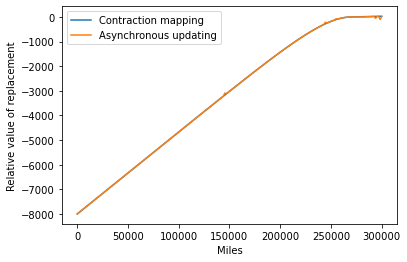

In [39]:
# Relative value of replacement
plt.plot(x_grid, Q_sol_rust[:,1]-Q_sol_rust[:,0], label = "Contraction mapping")
plt.plot(x_grid, Q_sol_learn0[:,1]-Q_sol_learn0[:,0], label = "Asynchronous updating")
plt.xlabel("Miles")
plt.ylabel("Relative value of replacement")
plt.legend()

In [50]:
# Randomly pick a state every time
%time _ = bus_problem.Q_learn0(Q_init, x_init, 0.05, tol, buffer_size, max_iter, reset_freq = 1);

Iteration converged after 108,989 function updates
CPU times: user 20.5 s, sys: 11.1 s, total: 31.6 s
Wall time: 4.39 s


---

### Stochastic iteration

Now reconsider the term: $p(x'|x,a) \arg \max_{y \in \mathcal{Y}(x)} Q^k_{x'y}$. In some cases, this can be very expensive to compute, in particular when the transition probabilities $p(x'|x,a)$ are intractable or take on a complex form.

Recall that we are already drawing the next state $x^{k+1}$ from $p(x'|x,a)$ anyways. We can use this to get a very noisy estimate of the above expectation, and use averaging over many periods to smooth out the noise, sing the same principle as **stochastic optimization**.

Essentially, when we visit $(x^k,a^k)$ in iteration $k$ and get a draw of the following state $x^{k+1}$, this gives a noisy estimate of $Q(x^k,a^k)$:

$$\tilde{Q}(x^k,a^k) = u(x^k,a^k) + \beta \arg \max_{a'} Q^k(x^{k+1},a')$$

Because this estimate is noisy, we want to average it over multiple visits of $(x,a)$, so we do not fully update $Q$ to the new value.

#### Algorithm

> Initialize $k=0$, $x^0$, $Q^0$.
>
> For every $k=0,1,\dots$:
>- $a^k = \arg \max Q^k(x^k,a)$
>- Draw $x^{k+1}$ according to $p(x'|x^k,a^k)$
>- Get the target value: $\tilde{Q}(x^k,a^k) = u(x^k,a^k) + \beta \arg \max_{a'} Q^k(x^{k+1},a')$
>- Update:
>>  - $Q^{k+1}(x,a) = Q^{k}(x,a) + \alpha^k (\tilde{Q}(x^k,a^k) - Q^k(x,a))$ if $(x,a) = (x^k,a^k)$
>>  - $Q^{k+1}(x,a) = Q^k(x,a)$ otherwise

### 2nd issue: Convergence

With the new form of updating, we no longer have the convergence guarantees of the contraction mapping.

Instead, $Q^k$ will behave more like a random variable. If $\alpha^k$ is held fixed, it will never completely converge, only bounce around in the neighborhood of the true $Q$. 

However, there are conditions on the sequence of $\alpha^k$ which should guarantee convergence:

1. $\sum_{k=0}^\infty \alpha^k = \infty$
2. $\sum_{k=0}^\infty \alpha^k < \infty$

> Sutton and Barto (2020), p.33

In practice, these conditions are not strictly observed, particularly because they can lead to very slow convergence rates. However, for econometric applications, guaranteed convergence may be more important.


In [41]:
# Full Q-learning
@torch.jit.script
def Q_learn1_script(U, P, β:float, nbX:int, nbA:int, Q_init, x_init, α_k:float, eps:float, tol:float, buffer_size:int, max_iter:float = float('inf'), reset_freq:float = float('inf')):
    # Initialize
    Q_k = Q_init.clone()
    x_k = x_init
    a_k = Q_k[x_k].argmax()
    k = 0
    diff_buffer = torch.ones(buffer_size)*tol + 1

    while (torch.abs(torch.mean(diff_buffer)) > tol) and (k < max_iter):
        # epsilon-greedy choice of y
        if torch.rand(1) > eps:
            a_k = Q_k[x_k].argmax()
        else:
            a_k = torch.randint(nbA, (1,))[0].long()
        
        # draw next x
        x_k1 = torch.multinomial(P[:,x_k,a_k],1)[0]
        
        # Calculate the temporal difference and add to buffer
        TD = U[x_k,a_k] + β * Q_k[x_k1].max() - Q_k[x_k,a_k]
        diff_buffer[k % buffer_size] = TD
        
        # Update Q
        Q_k[x_k,a_k] += α_k * TD
        
        # Update x, possibly randomly
        if k % reset_freq == 0:
            x_k = torch.randint(nbX,(1,))[0].long()
        else:
            x_k = x_k1        
            
        k += 1

    return Q_k, diff_buffer, k

def Q_learn1(self, Q_init, x_init, α_k:float, eps:float, tol:float, buffer_size:int, max_iter = float('inf'), reset_freq:float = float('inf')):
    Q_k, diff_buffer, k = Q_learn1_script(self.u, self.P, self.β, self.nbX, self.nbA, Q_init, x_init, α_k, eps, tol, buffer_size, max_iter, reset_freq)
    
    if torch.norm(diff_buffer) <= tol:
        print("Iteration converged after " + "{:,}".format(k) + " function updates")
    else:
        print("Hit maximum iterations after " + "{:,}".format(k) + " function updates")   
    
    return Q_k, diff_buffer

dynamic_problem.Q_learn1 = Q_learn1

In [61]:
x_init = torch.tensor(0)
α_k = 0.1
eps = 0.04
tol = 1e-8
buffer_size = bus_problem.nbX*bus_problem.nbA
max_iter = 1000000
reset_freq = 20

%time Q_sol_learn1, diff_buffer_learn1 = bus_problem.Q_learn1(Q_init, x_init, α_k, eps, tol, buffer_size, max_iter, reset_freq)

Hit maximum iterations after 1,000,000 function updates
CPU times: user 35.8 s, sys: 108 ms, total: 35.9 s
Wall time: 35.9 s


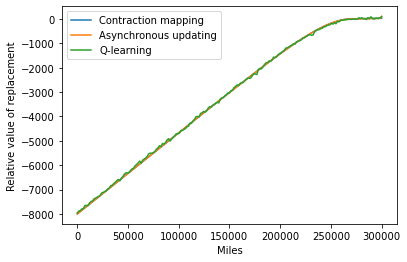

In [55]:
# Relative value of replacement
plt.plot(x_grid, Q_sol_rust[:,1]-Q_sol_rust[:,0], label = "Contraction mapping")
plt.plot(x_grid, Q_sol_learn0[:,1]-Q_sol_learn0[:,0], label = "Asynchronous updating")
plt.plot(x_grid, Q_sol_learn1[:,1]-Q_sol_learn1[:,0], label = "Q-learning")
plt.xlabel("Miles")
plt.ylabel("Relative value of replacement")
plt.legend()

--- 
# Deep Q-learning

![What a deep neural net looks like](https://spectrum.ieee.org/media-library/a-structure-of-lines-connecting-dots.png?id=27528385&width=605&quality=80)

The recent breakthroughs linked at the beginning of this notebook were only made possible by combining Q-learning with state of the art **deep neural networks**. This is because they face often face extremely large and complex state spaces. However, in most interesting problems, there will be some underlying structure that makes the Q-values similar for similar values of $(x,a)$. 

It thus makes sense to replace the table of Q-values with some universal function approximator for $Q(x,a)$, which will usually be a much more sparse representation. The most popular current choice are deep neural networks, as they have proven to adapt well to a large variety of structures. 

A nice advantage of the approximation is that when the Q-learning updates $Q$ at some $(x,a)$ pair, the Q function is updated for neighboring pairs as well, which can vastly improve convergence speed.

A second advantage is we no longer need to discretize the continuous state variable.

In the following, let $Q^\theta$ denote an approximation to $Q$ parametrized by $\theta$.


#### Algorithm

> Initialize $k=0$, $x^0$, $\theta^0$.
>
> For every $k=0,1,\dots$:
>- $a^k = \arg \max Q^{\theta^k}(x^k,a)$
>- Draw $x^{k+1}$ according to $p(x'|x^k,a^k)$
>- Get the target value: $\tilde{Q}^k = u(x^k,a^k) + \beta \arg \max_{a'} Q^{\theta^k}(x^{k+1},a') $
>- Update:
>>  - $\theta^{k+1} = \theta^k + \alpha^k \nabla_\theta \big( \tilde{Q}^k - Q^{\theta^k}(x^k,a^k) \big)$ 

**Notice**: the update step corresponds to gradient descent of the problem: $\arg \min_\theta \big(\tilde{Q}^k - Q^{\theta^k}_{x^ka^k}\big)^2 $


In [56]:
# Defining the neural network structure. 
from torch import nn
import torch.nn.functional as F
from torch import optim

class Fork_Net(nn.Module):
    def __init__(self, L1_size, L2_size, rescale_factor):
        super(Fork_Net, self).__init__()
        self.fc11 = nn.Linear(1, L1_size)
        self.fc12 = nn.Linear(L1_size, L2_size)
        self.fc13 = nn.Linear(L2_size, 1)
        self.fc21 = nn.Linear(1, L1_size)
        self.fc22 = nn.Linear(L1_size, L2_size)
        self.fc23 = nn.Linear(L2_size, 1)
        self.rescale_factor = rescale_factor

    def forward(self, X):
        x1 = F.relu(self.fc11(X*self.rescale_factor))
        x1 = F.relu(self.fc12(x1))
        x1 = self.fc13(x1)
        x2 = F.relu(self.fc21(X*self.rescale_factor))
        x2 = F.relu(self.fc22(x2))
        x2 = self.fc23(x2)
        return torch.cat([x1,x2], -1)

In [57]:
def deep_Q_learn(self, Q_net, x_init, α_k:float, eps:float, tol:float, buffer_size:int, max_iter:float = float('inf'), reset_freq:float = float('inf'), batch_size = 1):
    # Initialize
    opt_Q = optim.Adam(Q_net.parameters(), lr=α_k)
    x_k = torch.tensor([x_init])
    a_k = Q_net(self.x_grid[x_k]).argmax()
    k = 0
    diff_buffer = torch.ones(buffer_size)*tol + 1

    while (torch.mean(diff_buffer) > tol) and (k < max_iter):
        obj = 0
        
        for j in range(batch_size):
            # epsilon-greedy choice of y
            if random.random() > eps:
                a_k = Q_net(self.x_grid[x_k]).argmax()
            else:
                a_k = random.randint(0,1)
                
            # draw next x
            x_k1 = torch.multinomial(self.P[:,x_k[0],a_k],1)
            
            # Calculate the temporal difference and add to objective
            TD = self.u[x_k, a_k] + self.β * Q_net(self.x_grid[x_k1]).max().detach() - Q_net(self.x_grid[x_k])[a_k] # detach is used so that the gradient is not computed wrt to this term
            obj += (TD**2)/2
        
            # Update x, possibly randomly
            if (j + k*batch_size) % reset_freq == 0:
                # x_k = self.x_grid[random.randint(0,self.nbX-1)].unsqueeze(0) * 1.5
                x_k = torch.tensor([random.randint(0,self.nbX-1)])
            else:
                x_k = x_k1

        diff_buffer[k % buffer_size] = obj[0]/batch_size
            
        # Update network parameters
        opt_Q.zero_grad()
        (obj/batch_size).backward()
        opt_Q.step()
        
        k += 1

    if torch.norm(diff_buffer) <= tol:
        print("Iteration converged after " + "{:,}".format(k*batch_size) + " function updates")
    else:
        print("Hit maximum iterations after " + "{:,}".format(k*batch_size) + " function updates")   

    return Q_net, diff_buffer

dynamic_problem.deep_Q_learn = deep_Q_learn

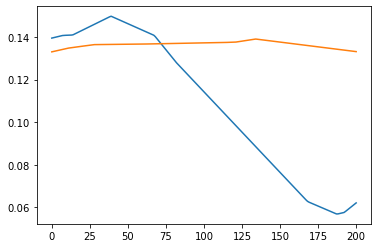

In [58]:
# Initialized network
Q_net = Fork_Net(16,16,1/3e5)
plt.plot(Q_net(x_grid[:,None]).detach()) 

Hit maximum iterations after 30,000 function updates
CPU times: user 8.17 s, sys: 188 ms, total: 8.35 s
Wall time: 8.36 s


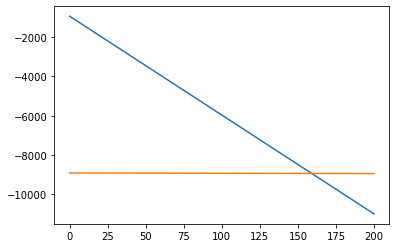

In [59]:
x_init = torch.tensor(0)
α_k = 5e-2
eps = 0.03
tol = 1e-8
buffer_size = bus_problem.nbX*bus_problem.nbA
max_iter = 1500
reset_freq = 20
batch_size = 20
%time Q_net, diff_buffer_deep = bus_problem.deep_Q_learn(Q_net, x_init, α_k, eps, tol, buffer_size, max_iter, reset_freq, batch_size)

plt.plot(Q_net(x_grid[:,None]).detach())

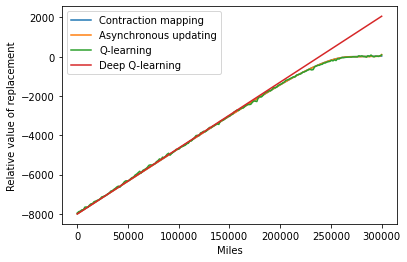

In [60]:
Q_sol_deep = Q_net(x_grid[:,None]).detach()

# Relative value of replacement
plt.plot(x_grid, Q_sol_rust[:,1]-Q_sol_rust[:,0], label = "Contraction mapping")
plt.plot(x_grid, Q_sol_learn0[:,1]-Q_sol_learn0[:,0], label = "Asynchronous updating")
plt.plot(x_grid, Q_sol_learn1[:,1]-Q_sol_learn1[:,0], label = "Q-learning")
plt.plot(x_grid, Q_sol_deep[:,1]-Q_sol_deep[:,0], label = "Deep Q-learning")
plt.xlabel("Miles")
plt.ylabel("Relative value of replacement")
plt.legend()


## References

Setup and notation:
- Rust, J. (1987). Optimal Replacement of GMC Bus Engines: An Empirical Model of Harold Zurcher. *Econometrica*, 55(5), 999-1033. 

Papers in economics:
- Iskhakov, F., Rust, J., & Schjerning, B. (2020). Machine learning and structural econometrics: contrasts and synergies. *The Econometrics Journal*, 23(3), S81-S124.
- Igami, M. (2020). Artificial intelligence as structural estimation: Deep Blue, Bonanza, and AlphaGo. *The Econometrics Journal*, 23(3), S1-S24.

Reference textbook:
- [Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.](https://www.andrew.cmu.edu/course/10-703/textbook/BartoSutton.pdf)

Web resources:
- [CS 285 at Berkeley, taught by Sergey Levine](https://rail.eecs.berkeley.edu/deeprlcourse/)
- [Spinning up by OpenAI](https://spinningup.openai.com/en/latest/)
